# Old

## TF 2 Rewrite of Zico MNIST [Attempt_1] 

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='valid', strides=(1, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid', strides=(1, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [7]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [9]:
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10


c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - 60s 31ms/step - loss: 0.2838 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.1039 - val_sparse_categorical_accuracy: 0.9703
Epoch 2/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9814 - val_loss: 0.0715 - val_sparse_categorical_accuracy: 0.9793
Epoch 3/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0915 - val_sparse_categorical_accuracy: 0.9768
Epoch 4/10
1500/1500 [==============================] - 28s 18ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0821 - val_sparse_categorical_accuracy: 0.9793
Epoch 5/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0977 - val_sparse_categorical_accuracy: 0.9807
Epoch 6/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0236 - spar

In [11]:
model.evaluate(test_images, test_labels, verbose=2)

c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 - 2s - loss: 0.1029 - sparse_categorical_accuracy: 0.9836 - 2s/epoch - 7ms/step


[0.10291782021522522, 0.9836000204086304]

### Evaluating against PGD images

In [24]:
# import fgsm and pgd adversarial sampels
pgd_images = np.load('pgd_images.npz')['images']
pgd_labels = np.load('pgd_images.npz')['labels']

pgd_images = np.reshape(pgd_images, (len(pgd_images), 28, 28, 1))

In [18]:
model.evaluate(pgd_images, pgd_labels, verbose=2)


c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4375/4375 - 46s - loss: 2.2921 - sparse_categorical_accuracy: 0.1348 - 46s/epoch - 11ms/step


[2.292105197906494, 0.1348285675048828]

### Evaluating against Unrestricted Adversarial Images

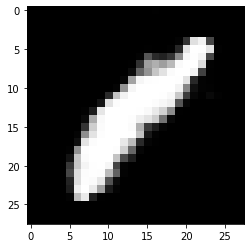

1
(94372, 28, 28, 1)
(94372,)


In [25]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z0/'
adv_files = []
X = []
y = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X.extend(data[keys[0]])

X = np.array(X)
y = np.array(y)
y_one_hot = np.take(np.eye(10), y, axis=0)

plt.imshow(X[10000], cmap='gray')
plt.show()
print(y[10000])
print(X.shape)
print(y.shape)

In [20]:
model.evaluate(X, y, verbose=2)

c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2950/2950 - 42s - loss: 2.2948 - sparse_categorical_accuracy: 0.1162 - 42s/epoch - 14ms/step


[2.294790744781494, 0.11616793274879456]

### Training model_adv on Unrestricted Adversarial Images

In [26]:
model_adv = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='valid', strides=(1, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid', strides=(1, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model_adv.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [27]:
# shuffle x and y
X, y = X[np.random.permutation(len(X))], y[np.random.permutation(len(y))]
# divde x and y into train and test with 0.3 test size
X_train, X_test, y_train, y_test = X[:int(0.7*len(X))], X[int(0.7*len(X)):], y[:int(0.7*len(y))], y[int(0.7*len(y)):]

In [16]:
# check if data is balanced
print(np.bincount(y_train))
print(np.bincount(y_test))

[6664 6594 6700 6670 6624 6551 6556 6513 6628 6560]
[2788 2731 2736 2792 2861 2886 2857 2861 2937 2863]


In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66060, 28, 28, 1)
(66060,)
(28312, 28, 28, 1)
(28312,)


#### Evaluate with Unrestricted Adversarial Examples

In [19]:
model_adv.evaluate(X_test, y_test, verbose=2)

885/885 - 12s - loss: 2.9395 - sparse_categorical_accuracy: 0.0986 - 12s/epoch - 14ms/step


[2.939526081085205, 0.09858010709285736]

#### Evaluate with PGD Samples

In [ ]:
model_adv.evaluate(pgd_images, pgd_labels, verbose=2)

## Run Train Zico without changing code

In [ ]:
!tf_upgrade_v2 --infile train_zico.py --outfile train_zico_v2.py

In [2]:
!tf_upgrade_v2 --infile models/zico_mnist.py --outfile test_zico_v2.py

INFO line 9:0: Not upgrading symbols because `tensorflow.compat.v1` was directly imported as `tf`.
INFO line 10:0: Renamed 'tf.disable_v2_behavior' to 'tf.compat.v1.disable_v2_behavior'
WARNING line 15:13: tf.get_variable requires manual check. tf.get_variable returns ResourceVariables by default in 2.0, which have well-defined semantics and are stricter about shapes. You can disable this behavior by passing use_resource=False, or by calling tf.compat.v1.disable_resource_variables().
INFO line 15:13: Renamed 'tf.get_variable' to 'tf.compat.v1.get_variable'
WARNING line 16:13: tf.get_variable requires manual check. tf.get_variable returns ResourceVariables by default in 2.0, which have well-defined semantics and are stricter about shapes. You can disable this behavior by passing use_resource=False, or by calling tf.compat.v1.disable_resource_variables().
INFO line 16:13: Renamed 'tf.get_variable' to 'tf.compat.v1.get_variable'
WARNING line 17:13: tf.get_variable requires manual check. t

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.compat.v1.disable_v2_behavior()


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# create train and test datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
# from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

class ZicoMNIST():
    def __init__(self):
        self.batch_size = 100
        self.learning_rate_base = 0.8
        self.learning_rate_decay = 0.99
        self.ragularatztion_rate = 0.0001
        self.traning_steps = 30000
        self.moving_average_decay = 0.99
        self.model_save_path = "./model_2"
        self.model_name = "model.ckpt"

    @tf.function
    def next_batch(self):
        xs, ys = next(iter(train_ds.batch(self.batch_size)))
        xs = tf.reshape(xs, [-1, 28, 28, 1])
        ys = tf.one_hot(ys, depth=10)
        return xs, ys

    def  train(self):
      with tf.compat.v1.variable_scope('net'):
        W0 = tf.compat.v1.get_variable('W0', dtype=tf.float32, shape=(4, 4, 1, 16))
        B0 = tf.compat.v1.get_variable('B0', dtype=tf.float32, shape=(16,))
        W2 = tf.compat.v1.get_variable('W2', dtype=tf.float32, shape=(4, 4, 16, 32))
        B2 = tf.compat.v1.get_variable('B2', dtype=tf.float32, shape=(32,))
        W5 = tf.compat.v1.get_variable('W5', dtype=tf.float32, shape=(1568, 100))
        B5 = tf.compat.v1.get_variable('B5', dtype=tf.float32, shape=(100,))
        W7 = tf.compat.v1.get_variable('W7', dtype=tf.float32, shape=(100, 10))
        B7 = tf.compat.v1.get_variable('B7', dtype=tf.float32, shape=(10,))
        x = tf.compat.v1.placeholder(
            tf.float32,[None,28,28,1], name='x-input')
        y_ = tf.compat.v1.placeholder(
            tf.float32,[None,10], name='y-input')
        y = tf.pad(tensor=x, paddings=[[0, 0], [1, 1], [1, 1], [0, 0]])
        y = tf.nn.conv2d(input=y, filters=W0, strides=[1, 2, 2, 1], padding='VALID')
        y = tf.nn.bias_add(y, B0)
        y = tf.nn.relu(y)
        y = tf.pad(tensor=y, paddings=[[0, 0], [1, 1], [1, 1], [0, 0]])
        y = tf.nn.conv2d(input=y, filters=W2, strides=[1, 2, 2, 1], padding="VALID")
        y = tf.nn.bias_add(y, B2)
        y = tf.nn.relu(y)
        y = tf.transpose(a=y, perm=[0, 3, 1, 2])
        y = tf.reshape(y, [tf.shape(input=y)[0], -1])
        y = tf.tensordot(y, W5 + B5, 1)
        y = tf.nn.relu(y)
        y = tf.tensordot(y, W7 + B7, 1)

        global_step = tf.Variable(0, trainable=False)
        variable_average = tf.train.ExponentialMovingAverage(
            self.moving_average_decay, global_step)
        variable_average_op = variable_average.apply(tf.compat.v1.trainable_variables())
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(input=y_, axis=1))
        cross_entropy_mean = tf.reduce_mean(input_tensor=cross_entropy)
        loss = cross_entropy_mean 
        learning_rate = tf.compat.v1.train.exponential_decay(
            self.learning_rate_base,
            global_step,
            x_train.shape[0]/self.batch_size,
            self.learning_rate_decay)
        train_step = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)\
                        .minimize(loss, global_step = global_step)
        with tf.control_dependencies([train_step, variable_average_op]):
            train_op = tf.no_op(name='train')

        saver = tf.compat.v1.train.Saver()
        with tf.compat.v1.Session() as sess:
            tf.compat.v1.initialize_all_variables().run()

            for i in range(self.traning_steps):
                # xs, ys = mnist.train.next_batch(self.batch_size)
                # get batch from train_ds.batch using batch_size tf2
                xs, ys = self.next_batch()
                _, loss_value, step  = sess.run([train_op, loss, global_step],
                                                feed_dict={x: xs.eval(), y_: ys.eval()})
                if i % 1000 ==0:
                    print("After %d training steps, loss on training "
                        " batch is %g."%(step, loss_value))
                    saver.save(
                        sess, os.path.join(self.model_save_path,self.model_name),
                        global_step=global_step)
                        
# mnist = input_data.read_data_sets("./data/", one_hot=True)
zico = ZicoMNIST()
zico.train()

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
After 0 training steps, loss on training  batch is 23073.7.


: 

: 

In [ ]:
def zico_template(images):
    model = ZicoMNIST(images)
    return model.logits

In [ ]:
net = tf.make_template('net', zico_template)

# TF 2 Rewrite of Zico MNIST [Attempt_2] (Includes test results)

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Tests on Zico MNIST Trained on Clean Examples

### Train model with Zico's Architecture

In [2]:
# resize x_train and x_test
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [4]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# train on mnist
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)


Epoch 1/10
1875/1875 [==============================] - 17s 8ms/step - loss: 0.3058 - accuracy: 0.9499
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0674 - accuracy: 0.9804
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0546 - accuracy: 0.9838
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0430 - accuracy: 0.9871
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0394 - accuracy: 0.9890
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0332 - accuracy: 0.9908
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0294 - accuracy: 0.9923
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0265 - accuracy: 0.9932
Epoch 9/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0310 - accuracy: 0.9933
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

[0.18679848313331604, 0.9803000092506409]

In [5]:
# save mnist_zico
model.save('assets/models/mnist_zico.h5')


### Test Zico's Model against Clean Examples

In [27]:
model.evaluate(x_test, y_test)

[0.21455569696724378, 0.9771]

### Test Zico's model against Unrestricted Adversarial Examples

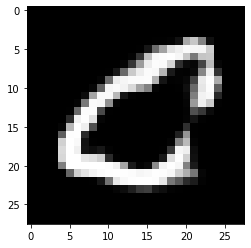

(94372, 28, 28, 1)
(94372,)


In [9]:
import numpy as np 
import matplotlib.pyplot as plt

# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z0/'
adv_files = []
X_adv = []
y_adv = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y_adv.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X_adv.extend(data[keys[0]])

X_adv = np.array(X_adv)
y_adv = np.array(y_adv)
y_one_hot = np.take(np.eye(10), y_adv, axis=0)

plt.imshow(X_adv[0], cmap='gray')
plt.show()
print(X_adv.shape)
print(y_adv.shape)

In [10]:
model.evaluate(X_adv, y_adv)

[2.5970321695068814, 0.16358666]

In [11]:
model.evaluate(x_test, y_test)

[0.21455569696724378, 0.9771]

## Tests on model_adv (trained on Unrestricted Adversarial Examples)

### Test model_adv against Unrestricted Adversarial Examples

In [3]:
# load model_adv
model_adv = tf.keras.models.load_model('assets/models/mnist_adv_model.h5')

In [17]:
model_adv.evaluate(X_adv, y_adv)

c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.002769992194468266, 0.9991947]

### Test model_adv against Clean Examples

In [25]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [26]:
model_adv.evaluate(ds_test)

[0.056600362118267265, 0.9858]

## Train Zico MNIST on Adversarial Examples

### Import libraries and load dataset

In [4]:
# Import the attack
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Generate FGSM for Zico MNIST

In [6]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [7]:
# load mnist
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

In [8]:

random_index = np.random.randint(test_images.shape[0])

original_image = test_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

In [14]:
# calculate error rate for FGSM attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 1.5, 0.1)
fgsm_images = []
fgsm_labels = []
model_adv_missclassifications = np.arange(0, len(epsilon_values))
model_missclassifications = np.arange(0, len(epsilon_values))


for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images.shape[0]):

        original_image = test_images[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels[i]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

        adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

        # adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
        # adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)
        
        # add fgsm image to list
        fgsm_images.append(adv_example_untargeted_label)
        fgsm_labels.append(original_label)

        # if np.argmax(adv_example_untargeted_label_pred) != original_label[0]:
        #     model_missclassifications[index] += 1
        # if np.argmax(adv_example_untargeted_label_pred_adv_model) != original_label[0]:
        #     model_adv_missclassifications[index] += 1
        
    
print(model_missclassifications)
print(model_adv_missclassifications)

np.savez('fgsm_images_zico', images=fgsm_images, labels=fgsm_labels)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


### Generate PGD for Zico MNIST

In [16]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [17]:
# calculate error rate for PGD attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 1.5, 0.1)
pgd_images = []
pgd_labels = []
model_adv_missclassifications = np.arange(0, len(epsilon_values))
model_missclassifications = np.arange(0, len(epsilon_values))

for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images.shape[0]):

        original_image = test_images[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)), dtype=tf.float32) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels[i]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

        adv_example_untargeted_label = projected_gradient_descent(model_fn=logits_model, x=original_image, eps=epsilon, eps_iter=0.01, targeted=False, nb_iter=200, norm=2)

        # adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
        # adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)
        
        # add pgd image to list
        pgd_images.append(adv_example_untargeted_label)
        pgd_labels.append(original_label)

        # if np.argmax(adv_example_untargeted_label_pred) != original_label[0]:
        #     model_missclassifications[index] += 1
        # if np.argmax(adv_example_untargeted_label_pred_adv_model) != original_label[0]:
        #     model_adv_missclassifications[index] += 1
        
    
print(model_missclassifications)
print(model_adv_missclassifications)

np.savez('pgd_images_zico', images=pgd_images, labels=pgd_labels)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


### Test model_adv on Zico MNIST based FGSM and PGD adversarial examples

In [5]:
# load fgsm and pgd images and labels
# import fgsm and pgd adversarial sampels
pgd_images_zico = np.load('pgd_images_zico.npz')['images']
pgd_labels_zico = np.load('pgd_images_zico.npz')['labels']

fgsm_images_zico = np.load('fgsm_images_zico.npz')['images']
fgsm_labels_zico = np.load('fgsm_images_zico.npz')['labels']

# reshape pgd and fgsm images to 28, 28, 1
pgd_images_zico = np.reshape(pgd_images_zico, (len(pgd_images_zico), 28, 28, 1))
fgsm_images_zico = np.reshape(fgsm_images_zico, (len(fgsm_images_zico), 28, 28, 1))

print(pgd_images_zico.shape)
print(pgd_labels_zico.shape)
print(fgsm_images_zico.shape)
print(fgsm_labels_zico.shape)

(140000, 28, 28, 1)
(140000, 1)
(140000, 28, 28, 1)
(140000, 1)


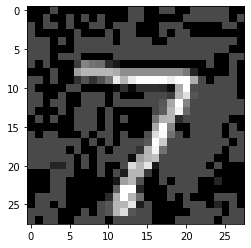

[[    0     1     2     3     4     5     6     7     8     9]
 [13720 15890 14448 14140 13748 12488 13412 14392 13636 14126]]


In [17]:
plt.imshow(fgsm_images_zico[10000], cmap='gray')
plt.show()

# show the first 1000 unique labels and counts
unique, counts = np.unique(fgsm_labels_zico, return_counts=True)
print(np.asarray((unique, counts)))

# take the first 1000 labels and images
fgsm_images_zico = fgsm_images_zico[:1000]
fgsm_labels_zico = fgsm_labels_zico[:1000]

In [6]:
model_adv.evaluate(pgd_images_zico, pgd_labels_zico)

4375/4375 [==============================] - 21s 4ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9854


[0.061959680169820786, 0.9854142665863037]

In [18]:
model_adv.evaluate(fgsm_images_zico, fgsm_labels_zico)

32/32 [==============================] - 1s 21ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9700


[0.15510913729667664, 0.9700000286102295]

### Train Zico MNIST on Adversarial Examples

In [ ]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model_madry = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# train on mnist
model_madry.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_madry.fit(
    x = fgsm_images_train,
    y = fgsm_labels_train,
    epochs=10
)
model_madry.evaluate(x_test, y_test)
